In [1]:
import tensorflow as tf
import numpy as np
from numpy import genfromtxt
import matplotlib
import matplotlib.pyplot as plt
from sklearn import preprocessing
from tensorflow.python.framework import ops,dtypes
%matplotlib inline

In [2]:
raw_data = genfromtxt('train.tsv', delimiter='\t', skip_header=1)

In [3]:
seq_length = 7
data_dim=4
hidden=10
batch_size=20
output_dim=1
learning_rate=0.001
iterations = 50000

In [4]:
data_x = raw_data

#closed price를 label로 사용한다 (many to one)
data_y = raw_data[:,[3]] 

train_size = int(len(data_y)*0.7)
test_size = len(data_y)-train_size

dataX=[]
dataY=[]

for i in range(0,len(data_y)-seq_length):
    _x = data_x[i:i+seq_length]
    _y = data_y[i+seq_length]
#     print(_x, "=> ",_y)
    dataX.append(_x)
    dataY.append(_y)
dataX, dataY = np.array(dataX), np.array(dataY)
# tf.nn.embedding_lookup()

In [5]:
# dataX = batch, sequence, features
# dataY = batch, label(close price)
print(dataX.shape,dataY.shape)
print(dataX[0])

(156034, 7, 4) (156034, 1)
[[  1.   1.  nan   1.]
 [  2.   1.  nan   2.]
 [  3.   1.  nan   2.]
 [  4.   1.  nan   2.]
 [  5.   1.  nan   2.]
 [  6.   1.  nan   2.]
 [  7.   1.  nan   2.]]


In [6]:
all_features = ops.convert_to_tensor(dataX, dtype=dtypes.float32)
all_labels = ops.convert_to_tensor(dataY, dtype=dtypes.float32)
print(all_features)
feature_queue, label_queue = tf.train.slice_input_producer([all_features, all_labels],shuffle=False)
# batch_x, batch_y = tf.train.shuffle_batch(tensors=[feature_queue,label_queue],batch_size=1,capacity=5000,
#                                  min_after_dequeue=100)
batch_x, batch_y = tf.train.batch(tensors=[feature_queue,label_queue],batch_size=batch_size,capacity=5000)

Tensor("Const:0", shape=(156034, 7, 4), dtype=float32)


In [7]:
cell = tf.contrib.rnn.GRUCell(num_units=hidden, activation=tf.tanh)
outputs, _states = tf.nn.dynamic_rnn(cell, batch_x, dtype=tf.float32)

In [8]:
def attention(input_, attention_size):
    input_shape = input_.shape
    sequence_length = input_.shape[1].value
    hidden_size = input_.shape[2].value
    
    w = tf.Variable(tf.random_normal(shape=[hidden_size, attention_size], stddev=0.1))
    b = tf.Variable(tf.random_normal(shape=[attention_size], stddev=0.1))
    u = tf.Variable(tf.random_normal(shape=[attention_size], stddev=0.1))
    
    print(b)
    print(tf.reshape(b ,[1,-1]))
    v = tf.tanh(tf.matmul(tf.reshape(input_, [-1, hidden_size]), w) + tf.reshape(b ,[1,-1]))
    vu = tf.matmul(v, tf.reshape(u, [-1, 1]))
    
    exps = tf.reshape(tf.exp(vu), [-1, sequence_length])
    
    alphas = exps/ tf.reshape(tf.reduce_sum(exps, 1), [-1,1])
    
    output = tf.reduce_sum(input_ * tf.reshape(alphas, [-1, sequence_length, 1]), axis=1)
    return output

In [9]:
attention_size=50
attention_output = attention(outputs, attention_size=attention_size)

<tf.Variable 'Variable_1:0' shape=(50,) dtype=float32_ref>
Tensor("Reshape:0", shape=(1, 50), dtype=float32)


In [10]:
print(attention_output.get_shape())

(20, 10)


In [11]:
prediction = tf.contrib.layers.fully_connected(outputs[:,-1],output_dim, activation_fn=None)

In [34]:
loss = tf.reduce_sum(tf.square(prediction-batch_y))
train = tf.train.AdamOptimizer(learning_rate).minimize(loss)

In [35]:
s = tf.Session()
coord = tf.train.Coordinator()
threads = tf.train.start_queue_runners(sess=s, coord=coord)
s.run(tf.global_variables_initializer())

for i in range(iterations):
    loss_, _ = s.run([loss,train])
    
    if i % 1000 ==0:
        print(i, ' loss : ',loss_)
    
coord.request_stop()
coord.join(threads)

0  loss :  nan
1000  loss :  nan
2000  loss :  nan


KeyboardInterrupt: 

In [11]:
# targets = tf.placeholder(tf.float32, [None, 1])
# predictions = tf.placeholder(tf.float32, [None, 1])
rmse = tf.sqrt(tf.reduce_mean(tf.square(batch_y-prediction)))
rmse_ = s.run([batch_y,prediction])

In [264]:
predic, real = s.run([prediction, batch_y])

<function matplotlib.pyplot.show>

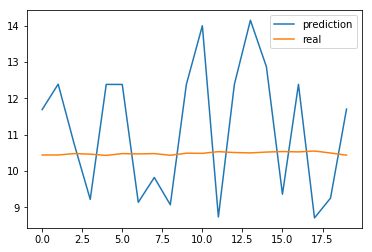

In [265]:
plt.plot(predic, label='prediction')
plt.plot(real, label='real')

plt.legend()

plt.show